# FATES SP LH analysis

In [81]:
import os
import copy

import xarray as xr
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import dask
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import gpflow

from matplotlib.patches import Rectangle
import seaborn as sns
from dask_jobqueue import PBSCluster
from dask.distributed import Client
from esem import gp_model
from sklearn.metrics import root_mean_squared_error
from esem.utils import get_random_params

from SALib.sample import fast_sampler
from SALib.analyze import fast

## PBS Cluster Setup

In [2]:
# Setup PBSCluster
cluster = PBSCluster(
    cores=1,                                     # The number of cores you want
    memory='25GB',                               # Amount of memory
    processes=1,                                 # How many processes
    queue='casper',                              # The type of queue to utilize
    local_directory='/glade/work/afoster',       # Use your local directory
    resource_spec='select=1:ncpus=1:mem=25GB',   # Specify resources
    project='P93300041',                         # Input your project ID here
    walltime='04:00:00',                         # Amount of wall time
    interface='ext',                             # Interface to use
)

/glade/work/afoster/conda-envs/ml_analysis/lib/python3.11/site-packages/dask_jobqueue/pbs.py:82: FutureWarning: project has been renamed to account as this kwarg was used wit -A option. You are still using it (please also check config files). If you did not set account yet, project will be respected for now, but it will be removed in a future release. If you already set account, project is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/glade/work/afoster/conda-envs/ml_analysis/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 35661 instead
  warnings.warn(


In [3]:
cluster.scale(30)

/glade/work/afoster/conda-envs/ml_analysis/lib/python3.11/site-packages/dask_jobqueue/pbs.py:82: FutureWarning: project has been renamed to account as this kwarg was used wit -A option. You are still using it (please also check config files). If you did not set account yet, project will be respected for now, but it will be removed in a future release. If you already set account, project is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)


In [4]:
client = Client(cluster)

## Helper Functions

In [5]:
def normalize(var):
    return (var - min(var))/(max(var) - min(var))

In [6]:
def unnormalize(norm_var, raw_var):
    return norm_var*np.array(max(raw_var) - min(raw_var)) + np.array(min(raw_var))

In [7]:
def split_dataset(var, params, n_test):

    # target variable (excluding default [0])
    Y = var[1:].values

    # test and training parameters
    X_test, X_train = params[:n_test], params[n_test:]

    # test and training output
    y_test, y_train = Y[:n_test], Y[n_test:]

    return X_test, X_train, y_test, y_train

In [8]:
def train_emulator(num_params, X_train, y_train):

    # create kernel
    kernel_linear = gpflow.kernels.Linear(active_dims=range(num_params),
                                          variance=1)
    kernel_matern32 = gpflow.kernels.Matern32(active_dims=range(num_params),
                                              variance=1,
                                              lengthscales=np.tile(1, num_params))
    kernel = kernel_linear + kernel_matern32

    # define emulator model and train
    emulator = gp_model(np.array(X_train), np.array(y_train), kernel=kernel)
    emulator.train()

    return emulator

In [9]:
def test_emulator(emulator, params, test, var):

    # predict test points with emulator
    pred, pred_var = emulator.predict(params)
    df = {f'{var}_test': test,
          f'{var}_pred': pred,
          f'{var}_var': pred_var}

    return pd.DataFrame(df)

In [10]:
def fourier_sensitivity(emulator):

    # fourier amplitude sensitivity test w/emulator
    problem = {
        'names': ppe_params.columns,
        'num_vars': num_params,
        'bounds': [[0, 1]],
    }

    sample = fast_sampler.sample(problem, 1000, M=4, seed=None)
    Y, _ = emulator.predict(sample)
    FAST = fast.analyze(problem, Y, M=4, num_resamples=100, conf_level=0.95,
                        print_to_console=False, seed=None)
    sens = pd.DataFrame.from_dict(FAST)
    sens.index = sens.names
    df_sens = sens.sort_values(by=['S1'], ascending=False)

    return df_sens

In [11]:
def oaat_sensitivity(ppe_params, emulator):
    
    num_params = len(ppe_params.columns)

    # hold all parameters at median value
    n = 50
    unif = pd.concat([pd.DataFrame(np.tile(0.5, n))]*num_params, axis=1)
    unif.columns = ppe_params.columns
    s = np.linspace(0, 1, n)
    param = np.array([])
    oaats = np.array([])
    vars = np.array([])
    samps = np.array([])
    sample = unif
    for i, p in enumerate(ppe_params.columns):
        sample[p] = s
        oaat, v = emulator.predict(sample.values)
        sample[p] = np.tile(0.5, n)  # set column back to median
        oaats = np.append(oaats, oaat)
        vars = np.append(vars, v)
        param = np.append(param, np.repeat(p, n))
        samps = np.append(samps, s)
    df = {'sample': samps,
      'predict': oaats,
      'variance': vars,
      'parameter': param}
    dataf = pd.DataFrame(df)
    return dataf

In [12]:
def train_and_test_var(ds, ppe_params, n_test, var, average_dim=None):

    # take average if required
    if average_dim is not None:
        average_var = ds[var].mean(dim=average_dim)
    else:
        average_var = ds[var]

    # split into testing and training
    params_test, params_train, var_test, var_train = split_dataset(average_var,
                                                                   ppe_params,
                                                                   n_test)
    # train emulator
    em = train_emulator(num_params, params_train, var_train)

    # create data frames for output
    var_preds = test_emulator(em, params_test, var_test, var)
    var_sens = fourier_sensitivity(em)
    var_oaat = oaat_sensitivity(ppe_params, em)

    return var_preds, var_sens, var_oaat, em

In [13]:
def train_and_test_allvars(ds, ppe_params, n_test, vars, outdir, file_tag,
                           average_dim=None):
    all_preds = []
    all_sens = []
    all_oaat = []
    all_em = dict()
    for var in vars:
        var_preds, var_sens, var_oaat, em = train_and_test_var(ds, ppe_params,
                                                               n_test, var,
                                                               average_dim)
        var_preds['variable'] = var
        var_preds.columns = ['test', 'pred', 'variance', 'variable']
        all_preds.append(var_preds)

        var_sens['variable'] = var
        all_sens.append(var_sens)
        
        var_oaat['variable'] = var
        all_oaat.append(var_oaat)
        
        if var in all_em:
            print('error')
        else:
            all_em[var] = em

    return pd.concat(all_preds), pd.concat(all_sens), pd.concat(all_oaat), all_em

In [14]:
def plot_emulator_validation(var_preds, var, units):

    sqrt = np.sqrt(var_preds[f"{var}_var"])
    rms = root_mean_squared_error(var_preds[f"{var}_test"], var_preds[f"{var}_pred"])

    plt.figure()
    plt.scatter(var_preds[f"{var}_test"], var_preds[f"{var}_pred"])
    plt.plot([min(var_preds[f"{var}_test"]), max(var_preds[f"{var}_test"])],
             [min(var_preds[f"{var}_test"]), max(var_preds[f"{var}_test"])],
             c='k', linestyle='--', label='1:1 line')
    plt.errorbar(var_preds[f"{var}_test"], var_preds[f"{var}_pred"],
                 yerr=2*sqrt, fmt="o")
    plt.text(min(var_preds[f"{var}_test"]), max(var_preds[f"{var}_test"]), 
             'RMSE = {}'.format(np.round(rms, 3)))
    plt.xlabel(f'FATES global mean annual mean {var} ({units})')
    plt.ylabel(f'Emulated global mean annual mean {var} ({units})')
    plt.legend(loc='lower right')

In [15]:
def plot_fourier_sensivity(sens_df, title):

    plt.figure(num=None, figsize=(12, 6), dpi=100, facecolor='w', edgecolor='k')
    plt.rcParams.update({'font.size': 12})

    ax = plt.subplot(1, 1, 1)
    ax.bar(sens_df.names, sens_df['ST'], color='lightgrey', label='interactions')
    ax.bar(sens_df.names, sens_df['S1'], color='darkolivegreen', label='main effects')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    plt.legend(loc='upper right')
    plt.ylabel('Proportion of total emulated variance (total=1)')
    plt.title(title)
    plt.tight_layout()

In [16]:
def plot_oaat_sens(ppe_params, emulator):

    num_params = len(ppe_params.columns)

    # hold all parameters at median value
    n = 21
    unif = pd.concat([pd.DataFrame(np.tile(0.5, n))]*num_params, axis=1)
    unif.columns = ppe_params.columns
    s = np.linspace(0, 1, n)

    sample = unif
    plt.figure(figsize=[18, 16])
    for i, p in enumerate(ppe_params.columns):
        sample[p] = s
        oaat, v = emulator.predict(sample.values)
        sample[p] = np.tile(0.5, n)  # set column back to median

        ax = plt.subplot(7, 5, i + 1)
        ax.fill_between(s, oaat - 3.0*v**0.5, oaat + 3.0*v**0.5, color='peru',
                        alpha=0.4)  # shade three standard deviations
        ax.plot(s, oaat, c='k')
        ax.set_xlabel(p)
    plt.tight_layout()

In [120]:
def plot_sampled_hist(pred_sampled, obs_mean, obs_var, varname, units, out_dir, ens):

    plt.figure(figsize=(7, 5))
    ax = plt.subplot(111)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    plt.xticks(fontsize=11)

    my_hist, bin_edges = np.histogram(pred_sampled, bins=40)
    maxv = my_hist.max()
    plt.xlabel(f"Emulated Global Annual {varname} ({units})", fontsize=12)
    plt.ylabel("Count", fontsize=12)
    plt.hist(pred_sampled, fc="darkgray", bins=40)
    ax.add_patch(Rectangle((obs_mean - np.sqrt(obs_var), 0), 2*np.sqrt(obs_var), maxv,
                           facecolor='red', alpha=0.4))
    plt.savefig(os.path.join(out_dir, f'{varname}_sample_{ens}.png'))

In [18]:
def implausibility_metric(pred, obs, pred_var, obs_var):

    top = np.abs(pred - obs)
    bottom = np.sqrt(pred_var + obs_var)

    imp = top/bottom

    return imp

In [114]:
def plot_sampled_implausibility(imp, title, plausibility_tolerance):

    plt.figure(figsize=(7, 5))
    ax = plt.subplot(111)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    plt.xticks(fontsize=11)    
    plt.xlabel(f"Implausibility Score", fontsize=12)
    plt.ylabel("Count", fontsize=12)
    
    my_hist, bin_edges = np.histogram(imp.flatten(), bins=40)

    # Define color thresholds
    lower_bound = plausibility_tolerance
    lower_tail_color = "#69B3A2"
    hist_center_color = "darkgray"
    
    # Init the list containing the color of each bin.
    colors = []
    for bin_edge in bin_edges:
    
        # Light blue: Assign a color to the bin if its edge is less than 'lower_bound'
        if bin_edge < lower_bound:
            colors.append(lower_tail_color)
        
        # Assign a color to the bin 
        else:
            colors.append(hist_center_color)

    plt.bar(
        bin_edges[:-1], 
        my_hist, 
        width=np.diff(bin_edges), 
        color=colors, 
        edgecolor='none'
    )

In [121]:
def emulator_sample(emulator, sample, obs_values, plausibility_tolerance,
                    varname, units, sim_var, pft, out_dir, ens):
    
    pred_sampled, pred_sampled_var = emulator.predict(sample)
    plot_sampled_hist(pred_sampled, obs_values.mean(), obs_values.var(), varname,
                      units, out_dir, ens)
    
    implaus = implausibility_metric(pred_sampled, obs_values.mean(),
                                pred_sampled_var, obs_values.var())
    plausible_values = np.where(implaus < plausibility_tolerance)[0]
    plot_sampled_implausibility(implaus, f"Implausibility for {sim_var} and {pft}",
                                plausibility_tolerance)

    sample_df = pd.DataFrame(sample)
    sample_df.columns = ppe_params.columns
    sample_df[f'{sim_var}_good'] = False
    if len(plausible_values) > 0:
        sample_df.loc[plausible_values, f'{sim_var}_good'] = True

    return sample_df

## Read in ensemble

In [259]:
ens = 300
ds = xr.open_dataset(f'../LH/LH{ens}_global.nc')

In [260]:
if ens == 500:
    lhckey = '/glade/u/home/afoster/FATES_Calibration/FATES_SP/LH/lh_key.csv'
    df = pd.read_csv(lhckey)
    ppe_params = df.drop(columns=['ensemble'])
elif ens == 300:
    lhckey = '/glade/work/afoster/FATES_calibration/FATES_SP_LH/lh_key_300.csv'
    df = pd.read_csv(lhckey)
    ppe_params = df

In [261]:
num_params = len(ppe_params.columns)
n_test = 50
plausibility_tolerance = 3
n_samp = 3000

In [262]:
sample = get_random_params(num_params, n_samp)
sample_update = sample
for i in range(len(sample_update)):
    sample_update[i][1] = 1.0
    sample_update[i][6] = 1.0

KeyError: 'fates_leaf_stomatal_slope_ballberry'

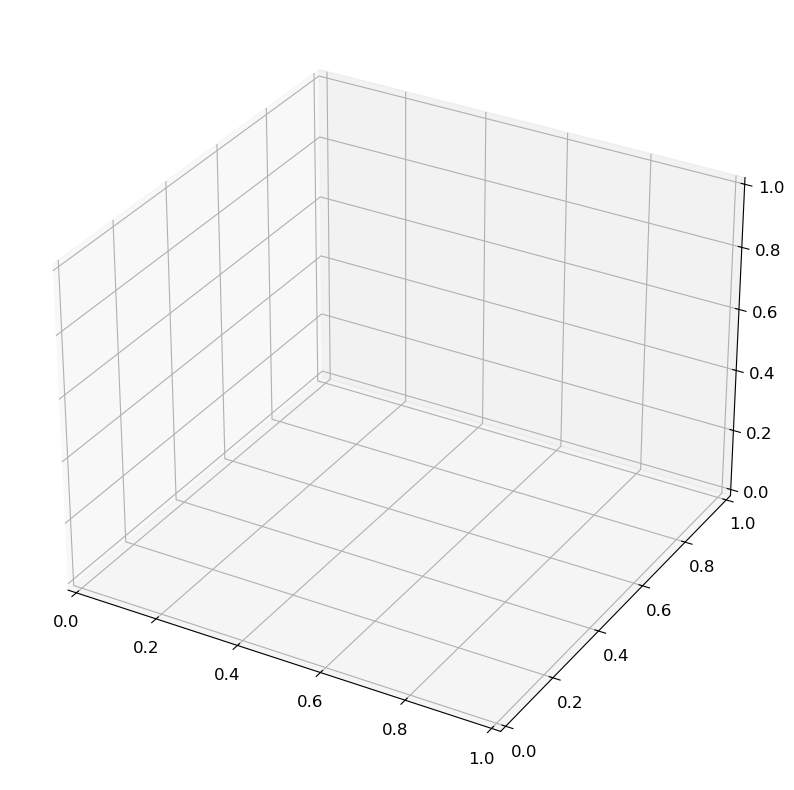

In [258]:
sample_df = pd.DataFrame(sample_update)
sample_df.columns = ppe_params.columns

param_1 = 'fates_leaf_vcmax25top'
param_2 = 'fates_leaf_stomatal_intercept'
param_3 = 'fates_leaf_stomatal_slope_ballberry'

ax = plt.figure(figsize=[10, 10]).add_subplot(projection='3d')
ax.scatter(ppe_params[param_1], ppe_params[param_2], ppe_params[param_3],
           zdir='y', c='red')
# ax.scatter(sample_df[param_1], sample_df[param_2], sample_df[param_3],
#            color='black', alpha=0.6, zdir='y')
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_zlim(0, 1)
ax.set_xlabel(param_1, fontsize=10)
ax.set_ylabel(param_2, fontsize=10)
ax.set_zlabel(param_3, fontsize=10)
ax.set_box_aspect(None, zoom=0.85)
plt.savefig('init_sample.png', bbox_inches='tight')

## Global Annual GPP

In [263]:
gpp_preds, gpp_sens, gpp_oaat, gpp_em = train_and_test_var(ds, ppe_params, n_test, 'GPP', average_dim=None)

In [264]:
gpp_preds.to_csv(f'../LH/LH_output_global/gpp_validation_{ens}.csv')
gpp_sens.to_csv(f'../LH/LH_output_global/gpp_sens_{ens}.csv')
gpp_oaat.to_csv(f'../LH/LH_output_global/gpp_oaat_{ens}.csv')

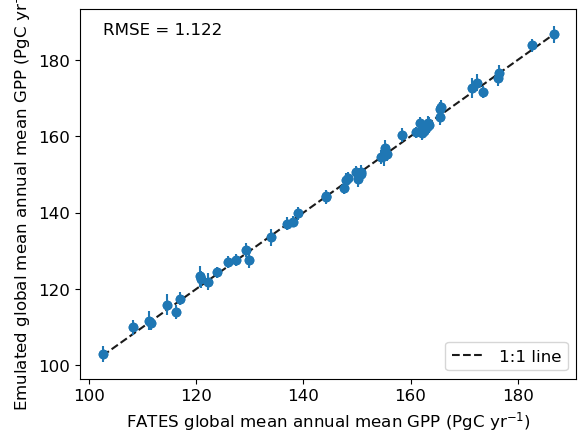

In [265]:
plot_emulator_validation(gpp_preds, 'GPP', 'PgC yr$^{-1}$')

In [266]:
gpp_obs = np.array([114, 116, 120])

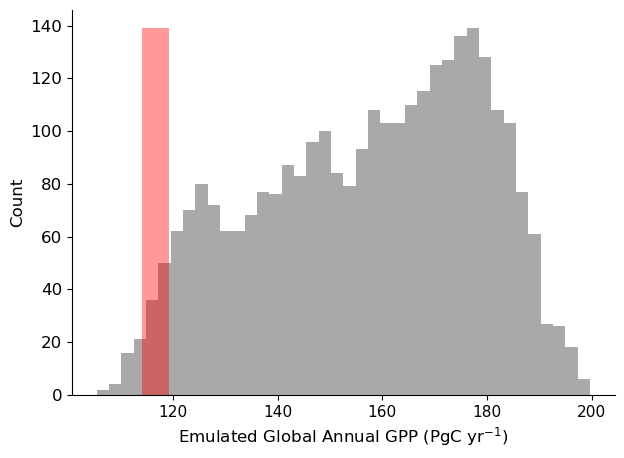

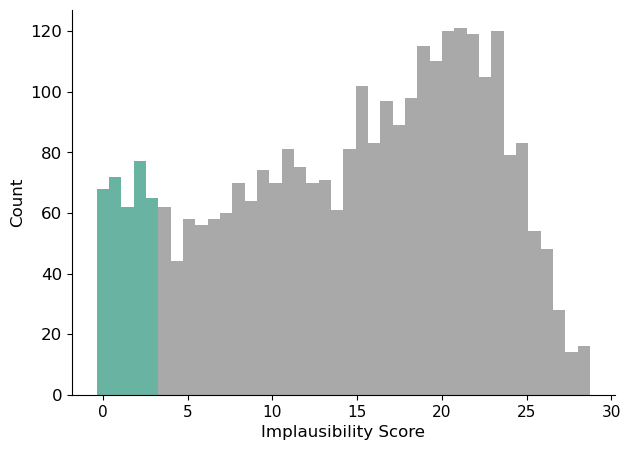

In [267]:
gpp_sample = emulator_sample(gpp_em, sample_update, gpp_obs,
                             plausibility_tolerance,
                             'GPP', 'PgC yr$^{-1}$', 'GPP',
                             f'global {ens}-member ensemble', '../LH/LH_output_global', ens)

## Global Annual Evapotranspiration

In [268]:
et_preds, et_sens, et_oaat, et_em = train_and_test_var(ds, ppe_params, n_test, 'EFLX_LH_TOT', average_dim=None)

In [269]:
et_preds.to_csv(f'../LH/LH_output_global/et_validation_{ens}.csv')
et_sens.to_csv(f'../LH/LH_output_global/et_sens_{ens}.csv')
et_oaat.to_csv(f'../LH/LH_output_global/et_oaat_{ens}.csv')

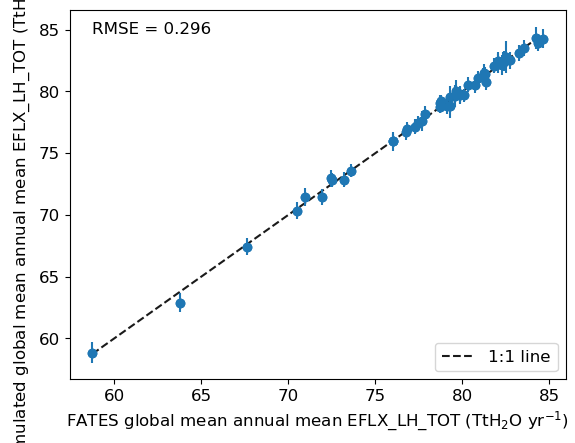

In [270]:
plot_emulator_validation(et_preds, 'EFLX_LH_TOT', 'TtH$_2$O yr$^{-1}$')

## Global Annual Sensible Heat

In [271]:
sh_preds, sh_sens, sh_oaat, sh_em = train_and_test_var(ds, ppe_params, n_test, 'FSH', average_dim=None)

In [272]:
sh_preds.to_csv(f'../LH/LH_output_global/sh_validation_{ens}.csv')
sh_sens.to_csv(f'../LH/LH_output_global/sh_sens_{ens}.csv')
sh_oaat.to_csv(f'../LH/LH_output_global/sh_oaat_{ens}.csv')

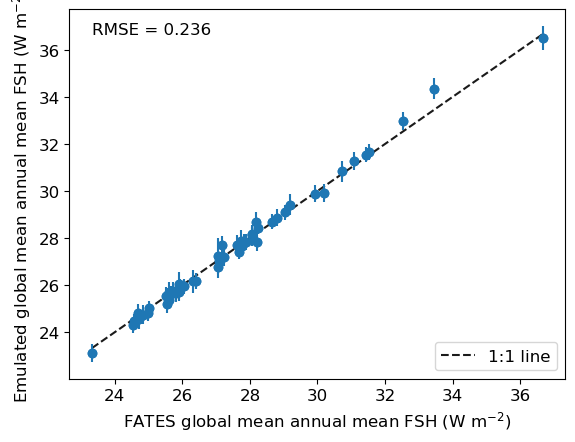

In [273]:
plot_emulator_validation(sh_preds, 'FSH', 'W m$^{-2}$')

In [274]:
sh_obs = np.array([40.4, 34.7, 39.0, 34.3])

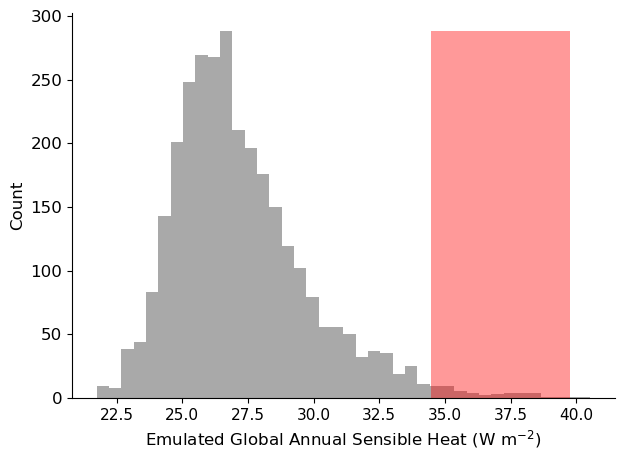

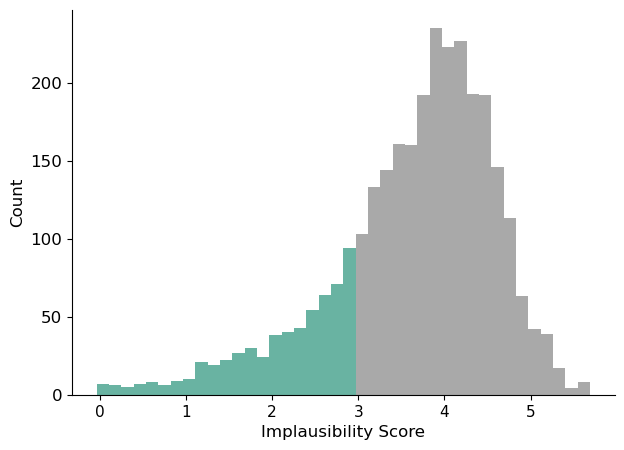

In [275]:
sh_sample = emulator_sample(sh_em, sample_update, sh_obs,
                            plausibility_tolerance,
                            'Sensible Heat', 'W m$^{-2}$', 'FSH',
                            f'global {ens}-member ensemble',
                            '../LH/LH_output_global', ens)